# Settings

In [1]:
USE_OFFSET = 0 
offset = 0.1
USE_BANDPASS = 1
window_size_seconds = 0.5
USE_NOTCH = 1
USE_ENVELOPE = 0
USE_ZSCORE = 0 
USE_SCALING = 1 
USE_FEATURESELECTION = 0
k = 20  # Number of top features to select
USE_TKEO = 1

# USE_ALIGNZERO_GLOBAL = Substract the mean to each channel
# USE_ALIGNZERO_LOCAL 
# USE_OFFSET = Generate more windows with offset
# offset 
# USE_BANDPASS = Filter with bandpass (window by window)
# USE_ZSCORE = Filter with zscore (window by window)
# USE_SCALING = Use feature scaling

print("Settings updated")

Settings updated


# Get data
## Train data

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Path and filenames
data_dir = r"C:\Quick_Disk\tonge_project\scripts\data\Noraxon"
file_names = ["Noraxon_20_06_cont_1.csv", "Noraxon_20_06_cont_2.csv"]

# Class mapping
class_map = {
    'l': 'l',
    'k': 'lf',
    'r': 'r',
    'e': 'rf',
    'f': 'f',
    'n': 'n',
    's': 's'
}

# Output container
windowed_data = {'l': [], 'lf': [], 'f': [], 'rf': [], 'r': [], 's': [], 'n': []}

# Constants
sampling_rate = 1500  # Hz
samples_per_window = int(window_size_seconds * sampling_rate)

# Process each file
for file_name in file_names:
    file_path = os.path.join(data_dir, file_name)
    df = pd.read_csv(file_path)

    # Ensure correct order and reset index for safety
    df = df.sort_values(by='window').reset_index(drop=True)

    # Group by 'window' to isolate each trial
    for window_id, window_group in df.groupby('window'):
        label_code = window_group['label'].iloc[0]  
        label = class_map.get(label_code)

        if label is None:
            continue  # Skip unknown classes

        # Check if window has enough samples
        if len(window_group) >= samples_per_window:
            trimmed_window = window_group.iloc[:samples_per_window][['ch_1', 'ch_2', 'ch_3']].to_numpy()
            windowed_data[label].append(trimmed_window)

print("Acquired train data")
print("Number of windows per class:")
for label, windows in windowed_data.items():
    print(f"Class '{label}': {len(windows)} windows")

if windowed_data['l']:
    num_samples = len(windowed_data['l'][0])
    print(f"\nNumber of samples in the first 'l' window: {num_samples}")


Acquired train data
Number of windows per class:
Class 'l': 40 windows
Class 'lf': 40 windows
Class 'f': 40 windows
Class 'rf': 40 windows
Class 'r': 40 windows
Class 's': 43 windows
Class 'n': 40 windows

Number of samples in the first 'l' window: 750


## Test data

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Path and filenames
files = ["Noraxon_20_06_cont_3.csv"]

# Output container
windowed_data_test = {'l': [], 'lf': [], 'f': [], 'rf': [], 'r': [], 's': [], 'n': []}

# Process each file
for file_name in files:
    file_path = os.path.join(data_dir, file_name)
    df = pd.read_csv(file_path)

    # Ensure correct order and reset index for safety
    df = df.sort_values(by='window').reset_index(drop=True)

    # Group by 'window' to isolate each trial
    for window_id, window_group in df.groupby('window'):
        label_code = window_group['label'].iloc[0]  
        label = class_map.get(label_code)

        if label is None:
            continue  # Skip unknown classes

        # Check if window has enough samples
        if len(window_group) >= samples_per_window:
            trimmed_window = window_group.iloc[:samples_per_window][['ch_1', 'ch_2', 'ch_3']].to_numpy()
            windowed_data_test[label].append(trimmed_window)

print("Acquired test data")
print("Number of windows per class:")
for label, windows in windowed_data_test.items():
    print(f"Class '{label}': {len(windows)} windows")

num_samples = len(windowed_data_test['l'][0])
print(f"\nNumber of samples in the first 'l' window: {num_samples}")



Acquired test data
Number of windows per class:
Class 'l': 9 windows
Class 'lf': 10 windows
Class 'f': 10 windows
Class 'rf': 10 windows
Class 'r': 10 windows
Class 's': 11 windows
Class 'n': 11 windows

Number of samples in the first 'l' window: 750


## Plot raw windows (only Train)

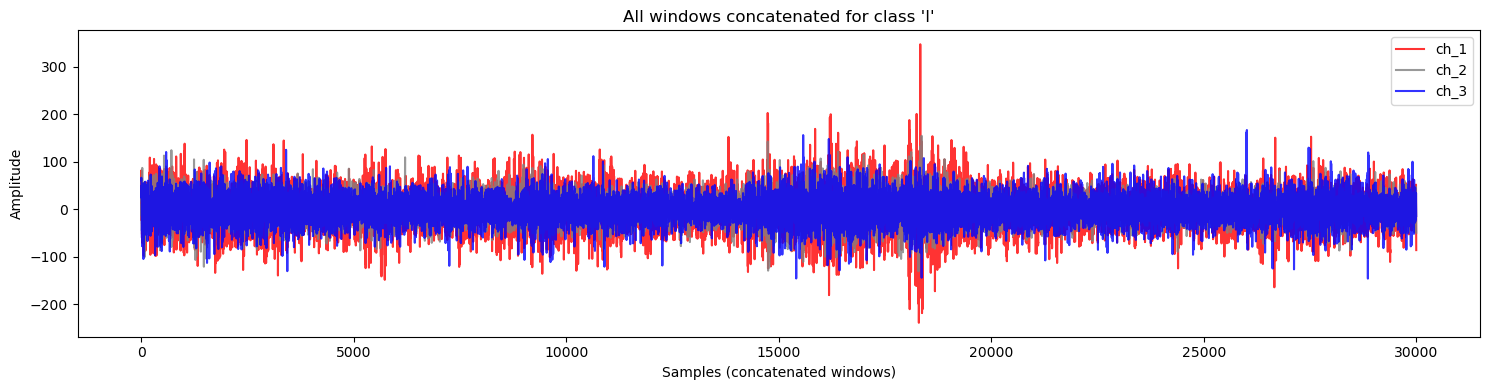

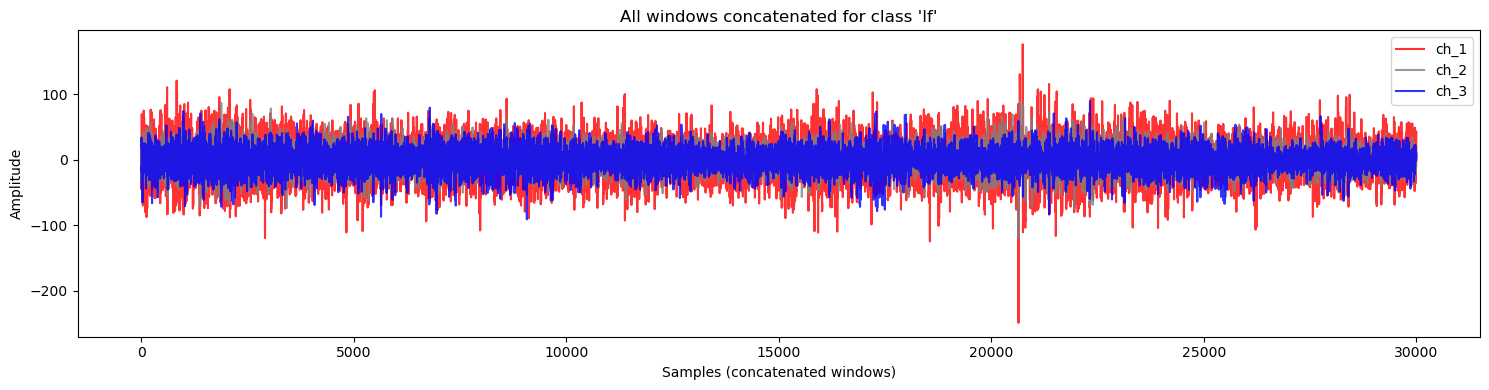

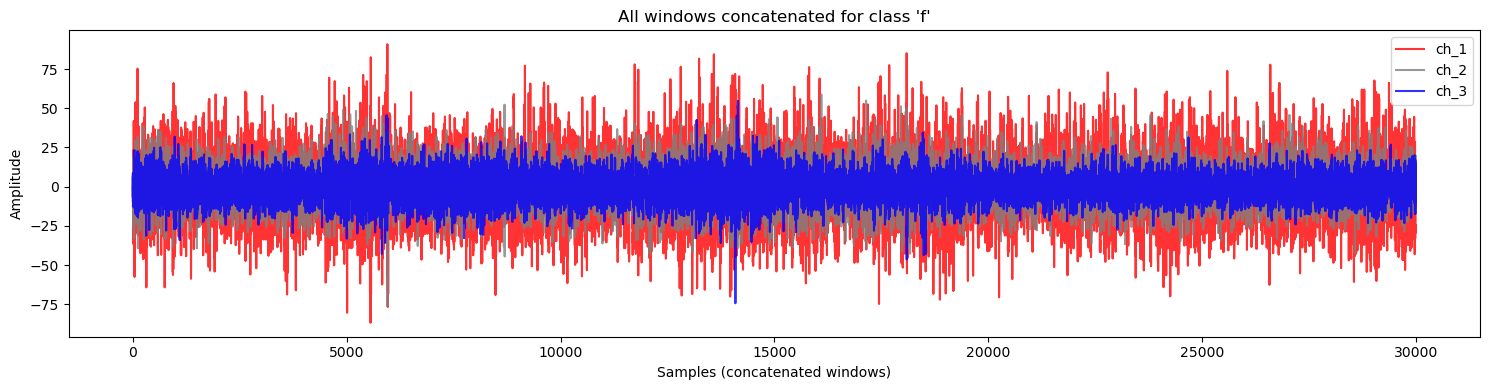

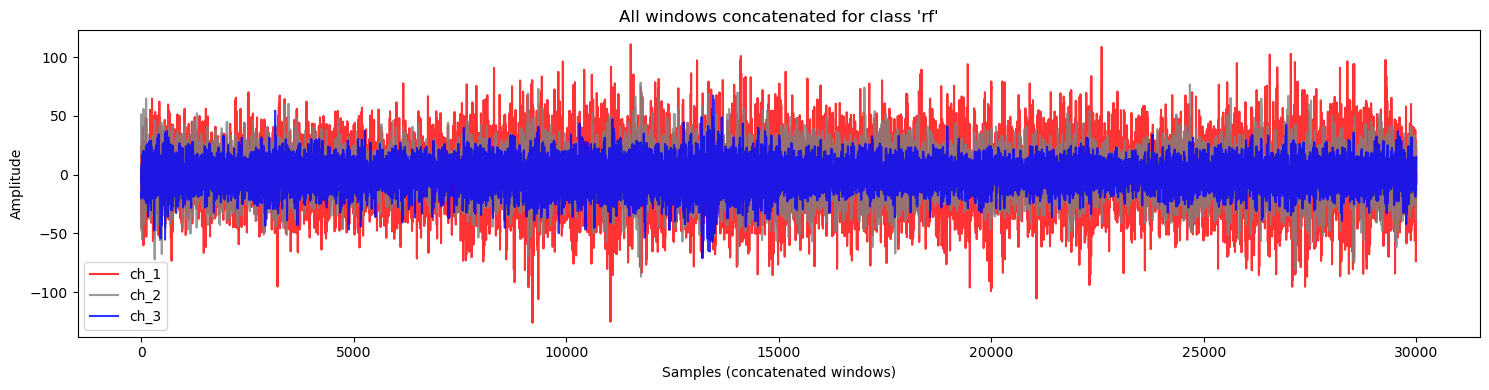

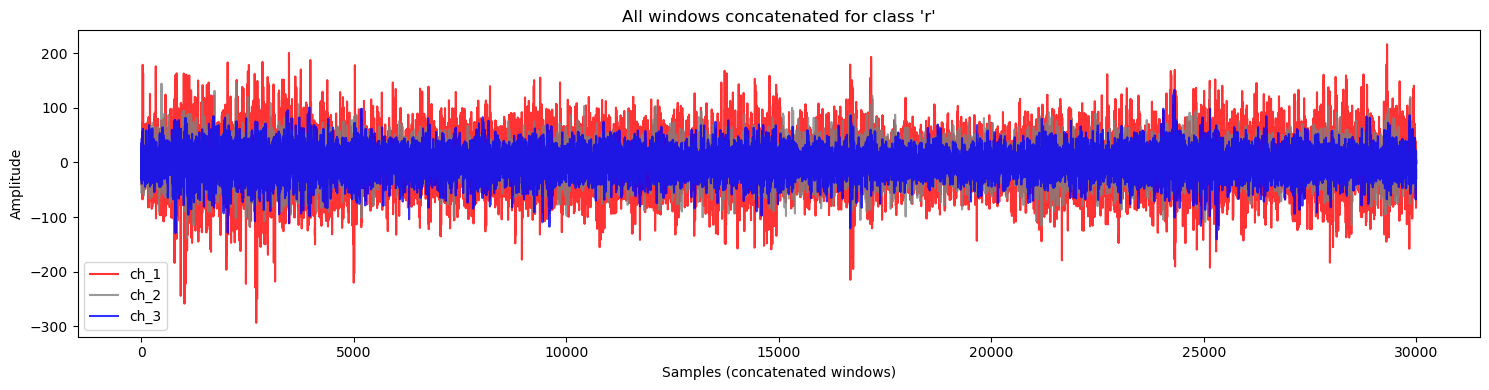

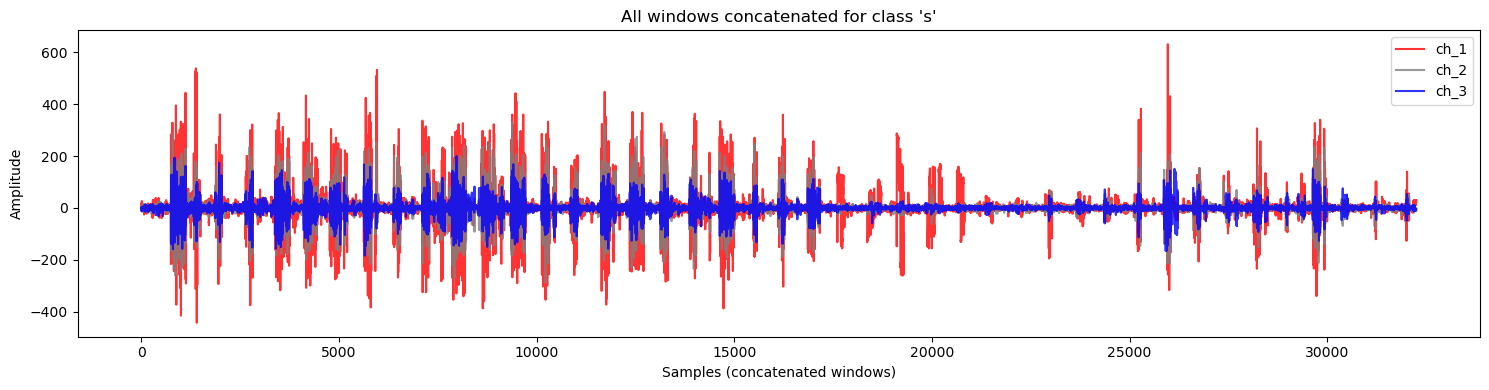

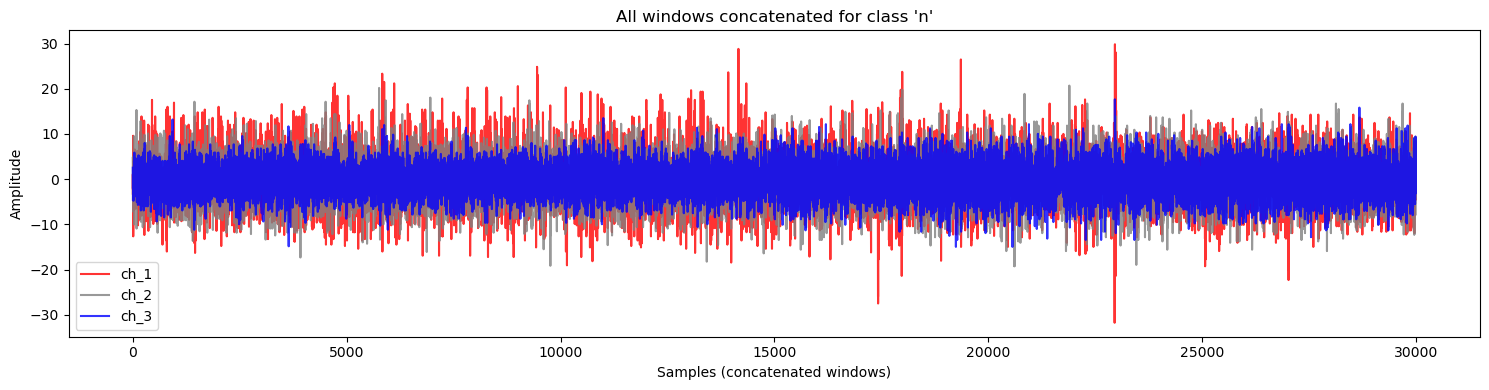

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Colors for channels
channel_colors = {'ch_1': 'red', 'ch_2': 'gray', 'ch_3': 'blue'}
channels = ['ch_1', 'ch_2', 'ch_3']

for class_label, windows in windowed_data.items():
    if not windows:
        print(f"No windows for class '{class_label}', skipping plot.")
        continue
    
    # Concatenate all windows along time axis (axis=0)
    # Each window shape: (samples, 3 channels)
    concatenated = np.vstack(windows)  # shape: (num_windows * samples, 3)
    
    plt.figure(figsize=(15, 4))
    
    for i, ch in enumerate(channels):
        plt.plot(concatenated[:, i], color=channel_colors[ch], label=ch, alpha=0.8)
    
    plt.title(f"All windows concatenated for class '{class_label}'")
    plt.xlabel("Samples (concatenated windows)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Process windows


## Filter windows

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch

def bandpass_filter(data, lowcut=5.0, highcut=50.0, fs=250.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def high_pass_filter(signal, cutoff=0.1, fs=250, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def notch_filter(signal, freq=50.0, fs=250, quality=30):
    nyquist = 0.5 * fs
    norm_freq = freq / nyquist
    b, a = iirnotch(norm_freq, quality)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def compute_envelope(signal, fs=250, cutoff=5.0):
    rectified = np.abs(signal)
    b, a = butter(4, cutoff / (0.5 * fs), btype='low')
    envelope = filtfilt(b, a, rectified)
    return envelope

def tkeo(signal):
    # Teager-Kaiser Energy Operator 
    output = np.zeros_like(signal)
    for i in range(1, len(signal) - 1):
        output[i] = signal[i]**2 - signal[i - 1] * signal[i + 1]  
    return output

def filter_dataset(dataset, dataset_name=""):
    filtered_dataset = {}

    for class_label, windows in dataset.items():
        if not windows:
            print(f"No windows for class '{class_label}' in {dataset_name}, skipping filter.")
            continue
        
        fwindows = []
        for window in windows:
            if window.shape[0] <= 30:
                print(f"Skipping short window of length {window.shape[0]} for class '{class_label}'")
                continue
            one_window = window.copy()
            for i in range(window.shape[1]): 
                if i in [0, 1, 2]:  # Filter ONLY CHANNELS 1, 2 AND 3

                    if USE_NOTCH == 1:
                        one_window[:, i] = bandpass_filter(one_window[:, i])
                        
                    if USE_BANDPASS == 1:
                        one_window[:, i] = bandpass_filter(one_window[:, i])

                    if USE_TKEO == 1:
                        one_window[:,i] = tkeo(one_window[:,i])

                    if USE_ENVELOPE == 1:
                        one_window[:, i] = compute_envelope(one_window[:, i])

                    if USE_ZSCORE == 1:
                        mean = one_window[:, i].mean()
                        std = one_window[:, i].std()
                        if std == 0:
                            std = 1
                        one_window[:, i] = (one_window[:, i] - mean) / std
                        
            fwindows.append(one_window)

        filtered_dataset[class_label] = fwindows

    print(f"Filtering completed for {dataset_name}")
    return filtered_dataset

# Filter train and test datasets
filtered = filter_dataset(windowed_data, "train set")
filtered_test = filter_dataset(windowed_data_test, "test set")


Filtering completed for train set
Filtering completed for test set


## Plot filtered windows (only Train)

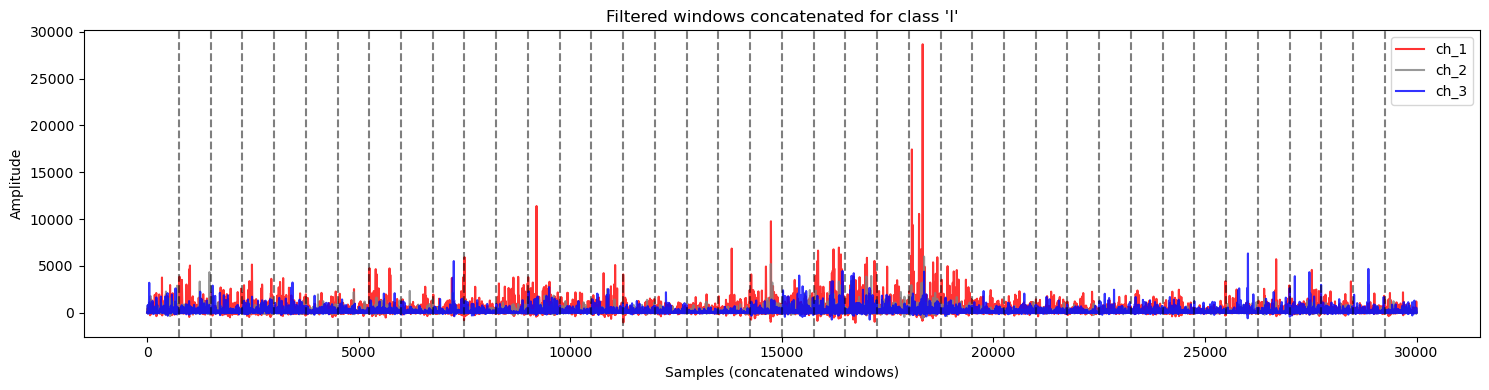

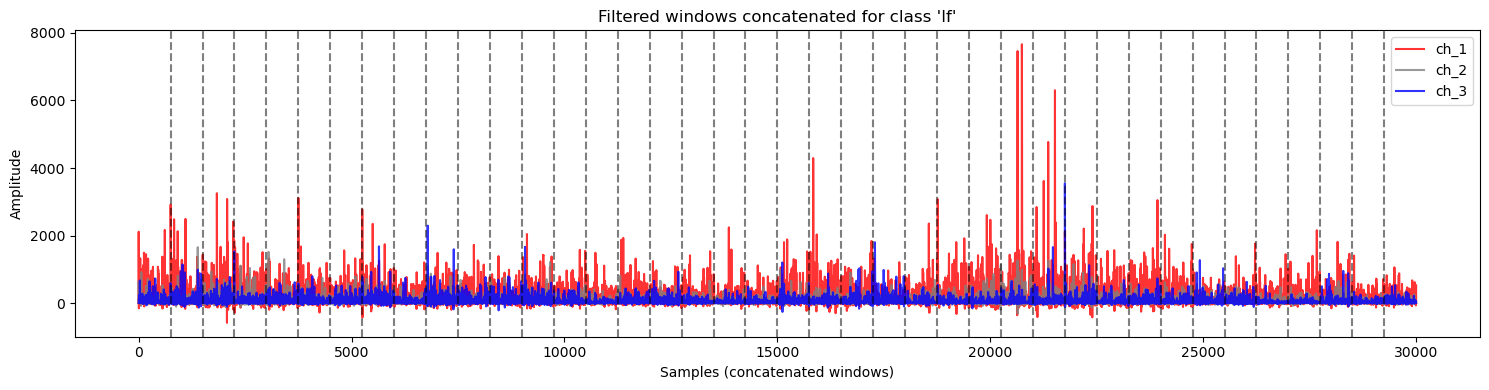

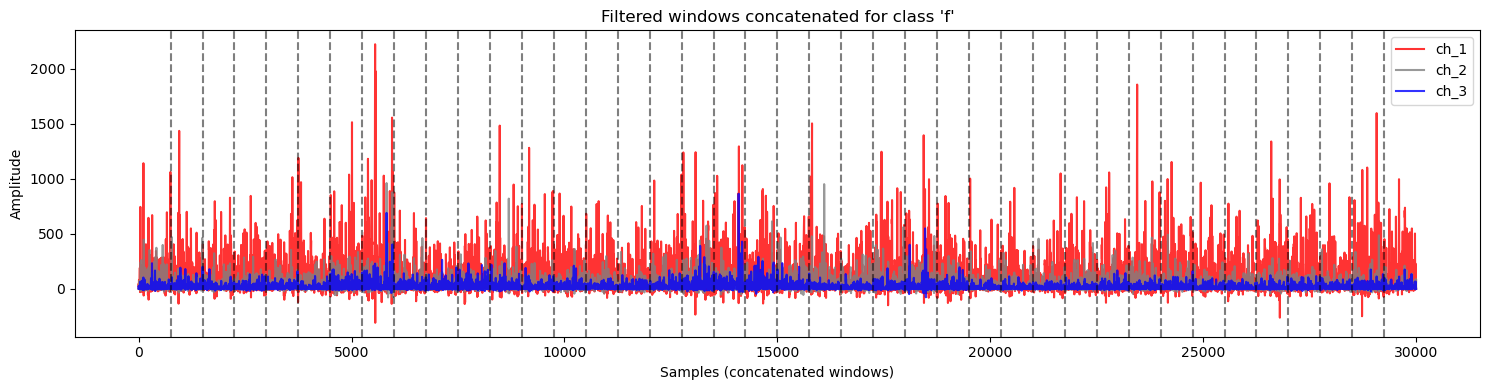

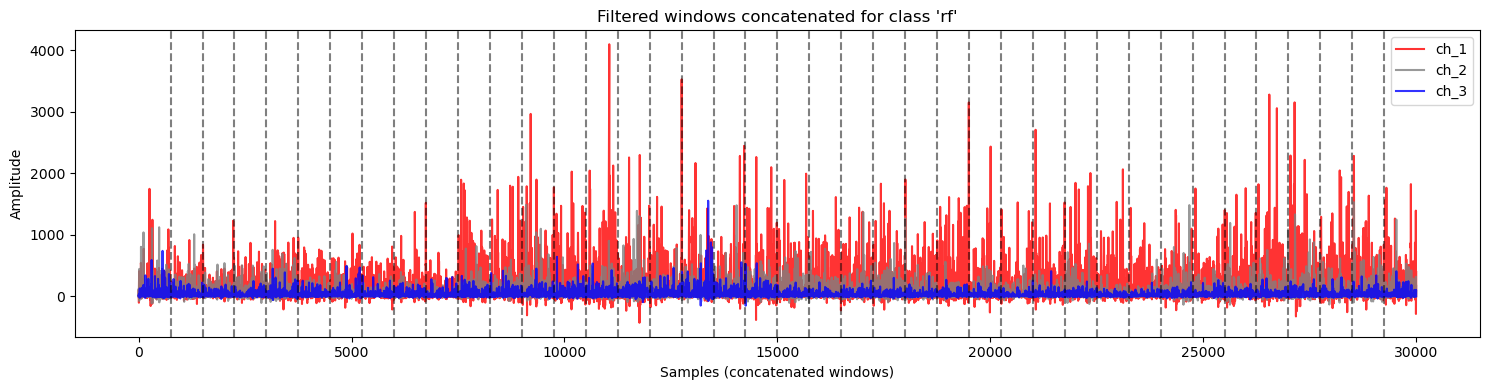

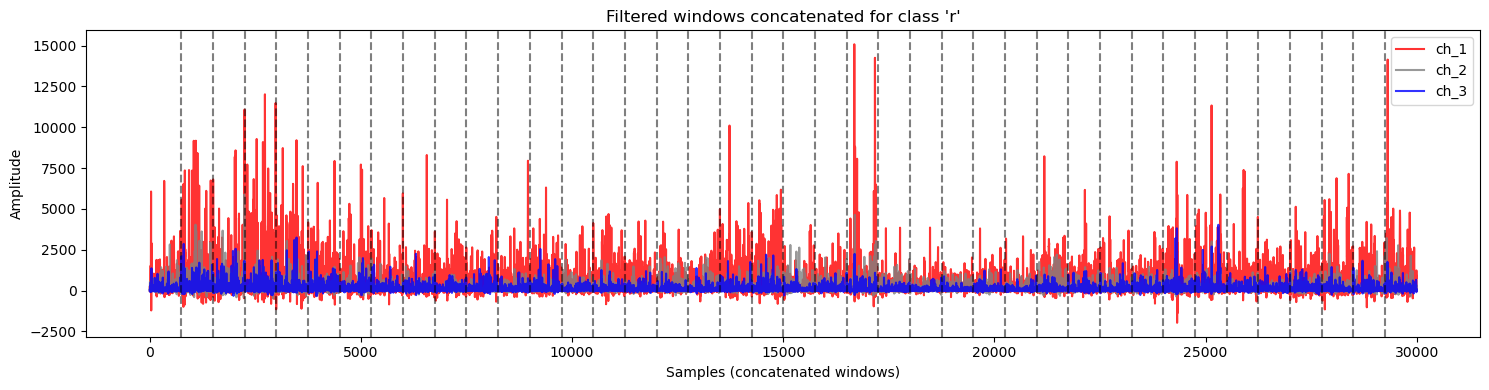

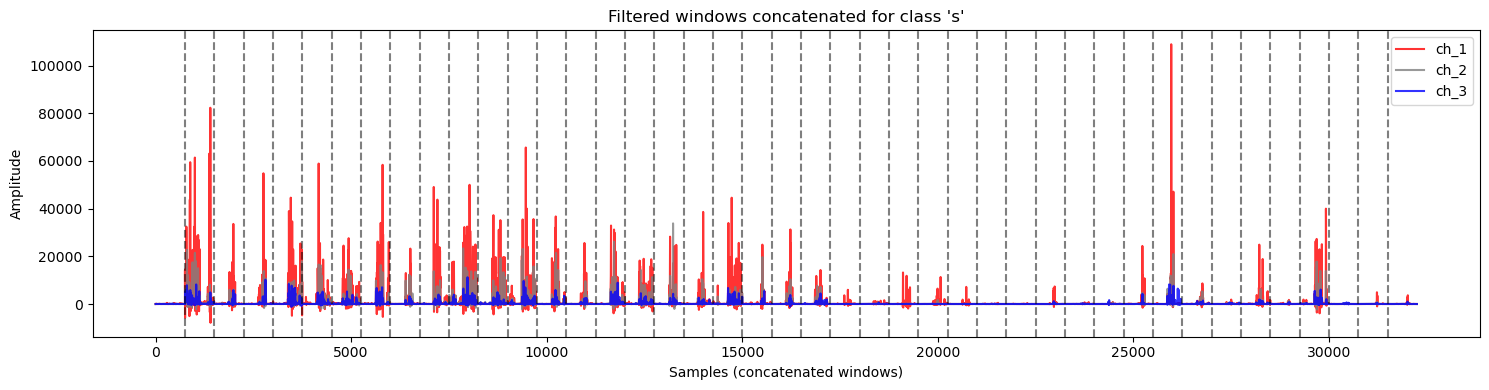

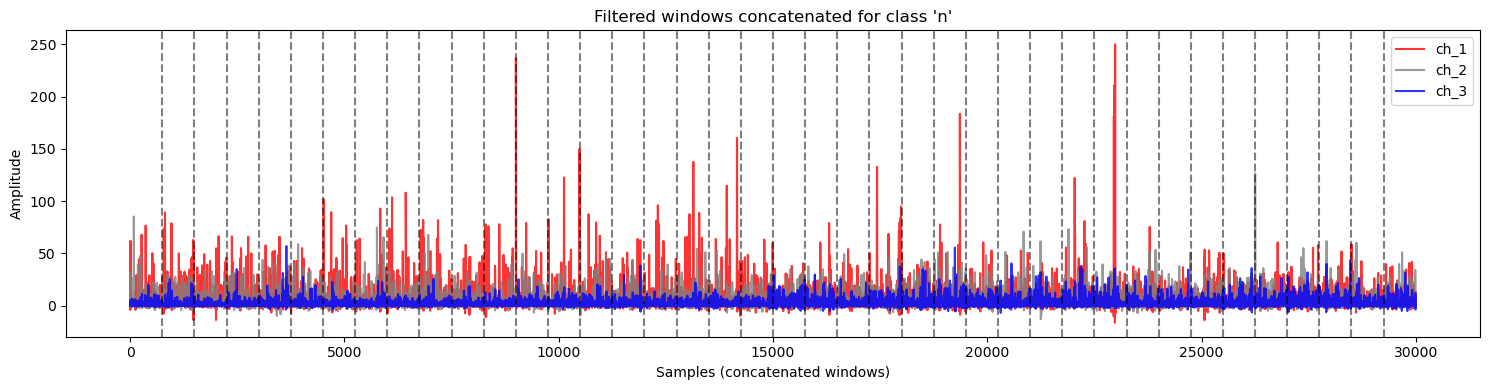

In [21]:
# Colors for channels
channel_colors = {'ch_1': 'red', 'ch_2': 'gray', 'ch_3': 'blue'}
channels = ['ch_1', 'ch_2', 'ch_3']

# For each label...
for class_label, windows in filtered.items():
    if not windows:
        continue

    #... concatenate
    concatenated = np.vstack(windows)
    plt.figure(figsize=(15, 4))

    # Plot each channel
    for i, ch in enumerate(channels):
        plt.plot(concatenated[:, i], color=channel_colors[ch], label=ch, alpha=0.8)
    
    # Add vertical lines between windows
    window_length = windows[0].shape[0]  # samples per window
    num_windows = len(windows)
    for w in range(1, num_windows):
        plt.axvline(x=w * window_length, color='black', linestyle='--', alpha=0.5)
    
    plt.title(f"Filtered windows concatenated for class '{class_label}'")
    plt.xlabel("Samples (concatenated windows)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Plot filtered windows (only Test)

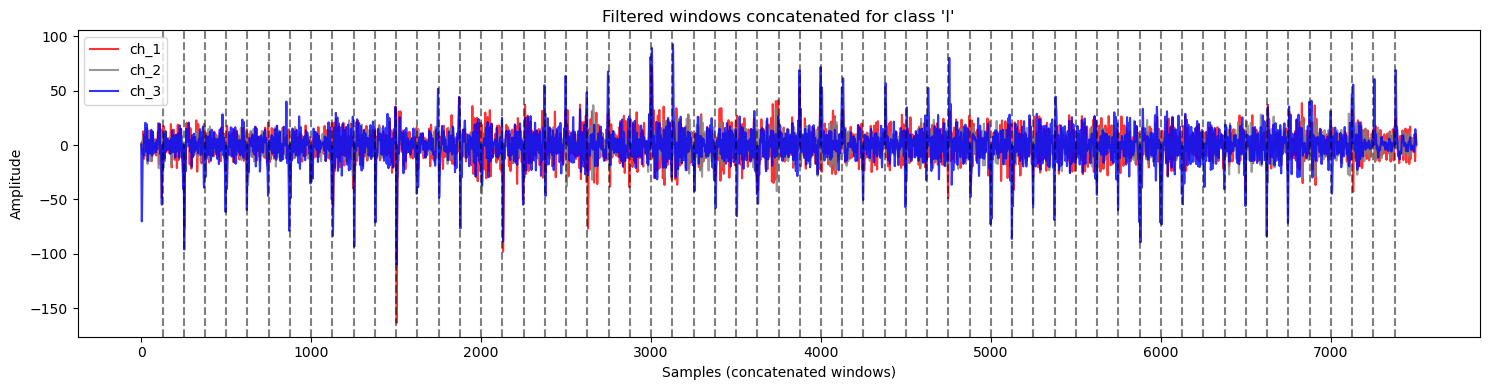

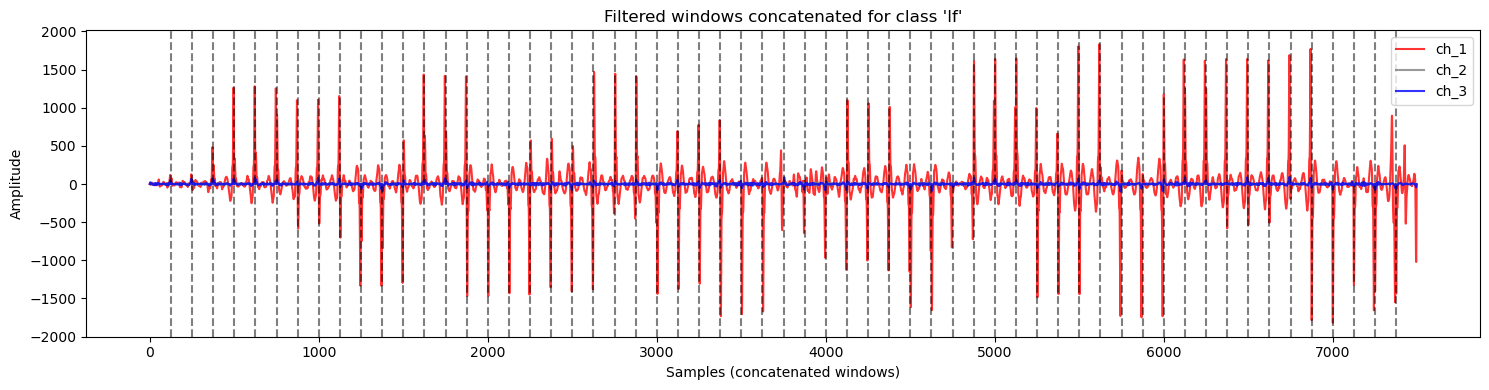

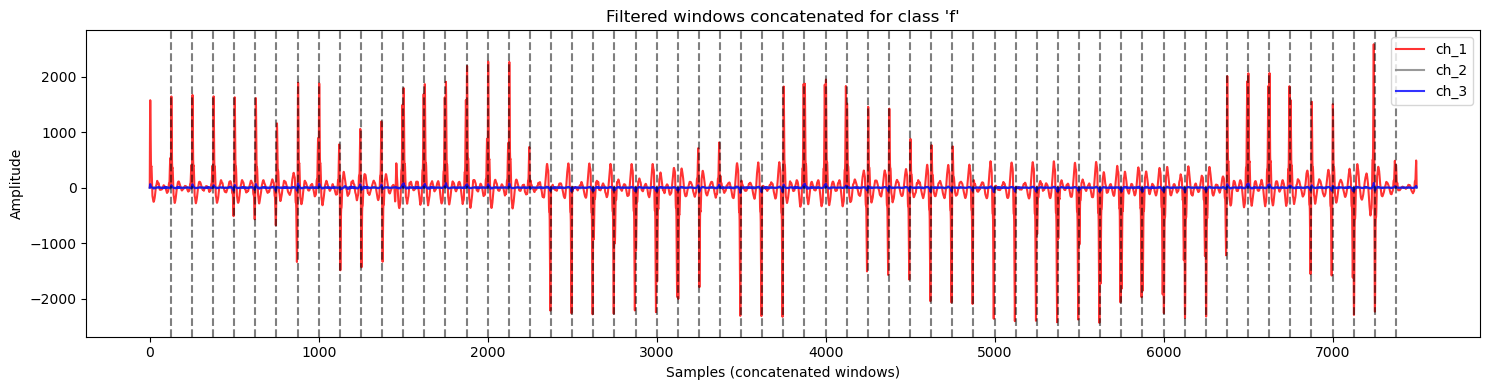

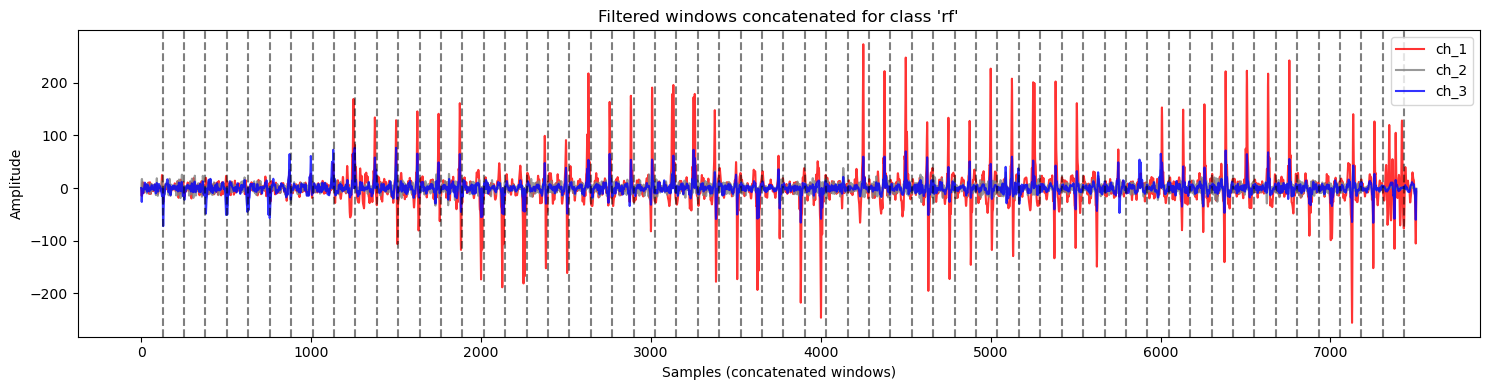

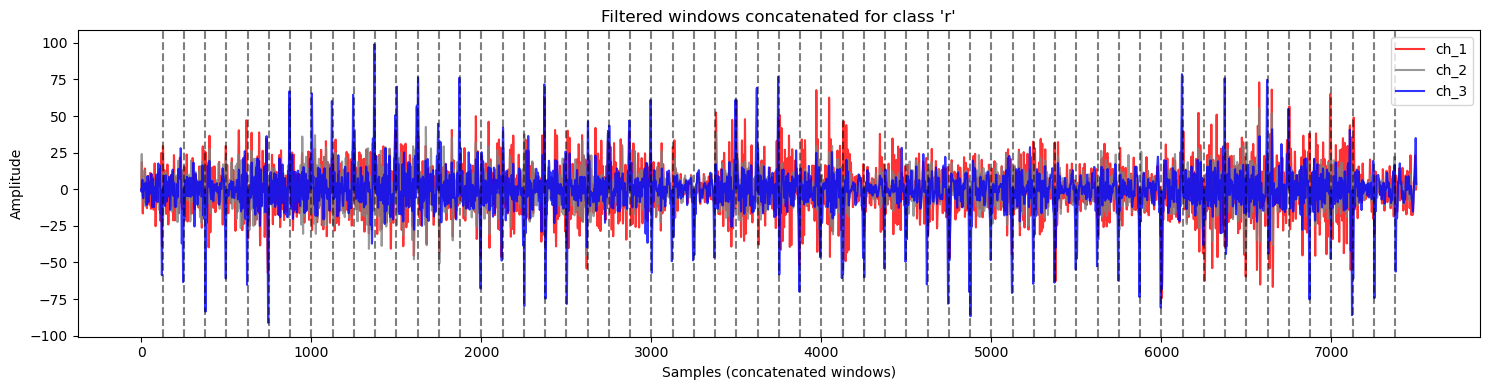

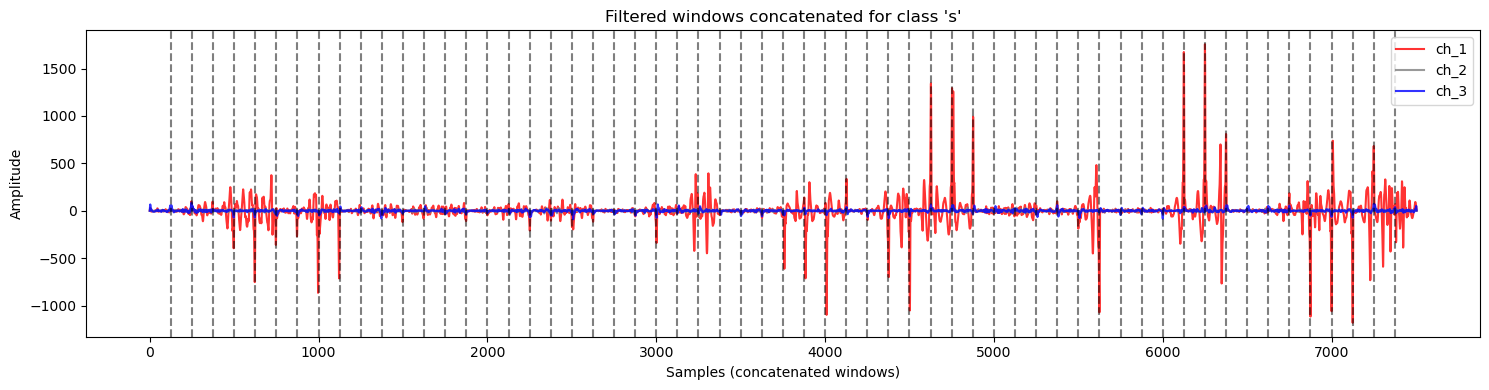

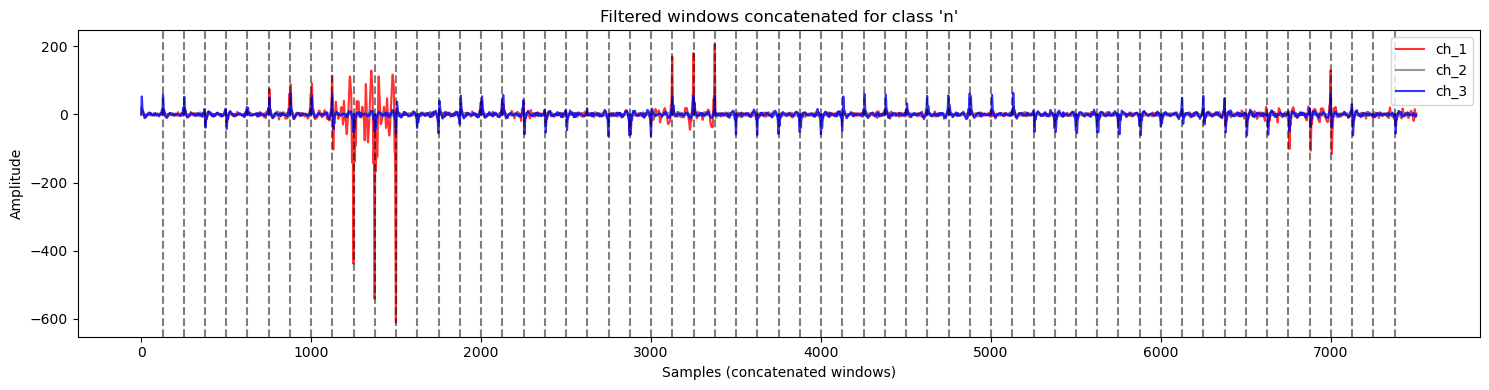

In [93]:
# Colors for channels
channel_colors = {'ch_1': 'red', 'ch_2': 'gray', 'ch_3': 'blue'}
channels = ['ch_1', 'ch_2', 'ch_3']

# For each label...
for class_label, windows in filtered_test.items():
    if not windows:
        continue

    #... concatenate
    concatenated = np.vstack(windows)
    plt.figure(figsize=(15, 4))

    # Plot each channel
    for i, ch in enumerate(channels):
        plt.plot(concatenated[:, i], color=channel_colors[ch], label=ch, alpha=0.8)
    
    # Add vertical lines between windows
    window_length = windows[0].shape[0]  # samples per window
    num_windows = len(windows)
    for w in range(1, num_windows):
        plt.axvline(x=w * window_length, color='black', linestyle='--', alpha=0.5)
    
    plt.title(f"Filtered windows concatenated for class '{class_label}'")
    plt.xlabel("Samples (concatenated windows)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Feature extraction

In [22]:
import numpy as np
import pandas as pd

# -------------- Feature functions 
def rms(signal):
    return np.sqrt(np.mean(signal**2))

def zero_crossings(signal):
    signs = np.sign(signal)
    for i in range(1, len(signs)):
        if signs[i] == 0:
            signs[i] = signs[i-1] if signs[i-1] != 0 else 1
    return np.sum(np.diff(signs) != 0)

def waveform_length(signal):
    return np.sum(np.abs(np.diff(signal)))

def mav(signal):
    return np.mean(np.abs(signal))

def iav(signal):
    return np.sum(np.abs(signal))

def rms_signed_difference(signal):
    mean_val = np.mean(signal)
    diff = signal - mean_val
    return np.sqrt(np.mean(diff**2))

def mean_frequency(signal, fs=250):
    # Compute FFT
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    fft_vals = np.abs(np.fft.rfft(signal))
    power = fft_vals ** 2
    if np.sum(power) == 0:
        return 0
    mf = np.sum(freqs * power) / np.sum(power)
    return mf

# -------------------

class_labels = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
channels = ['ch_1', 'ch_2', 'ch_3']
feature_names = ['RMS', 'RMS_SD', 'ZC', 'WL', 'MAV', 'STD', 'VAR', 'IAV', 'MF']

def extract_features(filtered_data):
    features = []
    labels = []

    for label in class_labels:
        for window in filtered_data.get(label, []):
            feats = []
            for ch_idx in range(len(channels)):
                ch_signal = window[:, ch_idx]
                feats.append(rms(ch_signal))
                feats.append(rms_signed_difference(ch_signal))
                feats.append(zero_crossings(ch_signal))
                feats.append(waveform_length(ch_signal))
                feats.append(mav(ch_signal))
                feats.append(np.std(ch_signal))
                feats.append(np.var(ch_signal))
                feats.append(iav(ch_signal))
                feats.append(mean_frequency(ch_signal))
                
            features.append(feats)
            labels.append(label)

    cols = []
    for ch in channels:
        for feat_name in feature_names:
            cols.append(f"{ch}_{feat_name}")

    X = pd.DataFrame(features, columns=cols)
    y = pd.Series(labels, name='label')
    return X, y

# Extract features for train and test
X, y = extract_features(filtered)
Xt, yt = extract_features(filtered_test)

print("--- Train:")
print(X.head())
print(y.head())

print("\n--- Test:")
print(Xt.head())
print(yt.head())


--- Train:
     ch_1_RMS  ch_1_RMS_SD  ch_1_ZC        ch_1_WL    ch_1_MAV    ch_1_STD  \
0  671.025783   520.551394       75  108885.224451  435.949126  520.551394   
1  892.287549   715.642835       53  121123.516981  540.976218  715.642835   
2  659.768114   524.757842       87  118016.612589  416.572736  524.757842   
3  902.350408   707.667123       83  148576.297544  579.889458  707.667123   
4  723.912856   564.720824       63  113039.993158  464.799014  564.720824   

        ch_1_VAR       ch_1_IAV   ch_1_MF    ch_2_RMS  ...   ch_2_MF  \
0  270973.753842  326961.844784  5.906649  500.710250  ...  6.618157   
1  512144.667434  405732.163503  5.263956  537.356326  ...  7.456120   
2  275370.793139  312429.551915  7.053424  279.130529  ...  6.357652   
3  500792.757643  434917.093812  6.074123  339.137000  ...  6.265289   
4  318909.608732  348599.260256  5.821022  298.992689  ...  6.051504   

     ch_3_RMS  ch_3_RMS_SD  ch_3_ZC       ch_3_WL    ch_3_MAV    ch_3_STD  \
0  555.432

# Classification

## Random Forest Tree

Random Forest Test Accuracy: 0.800


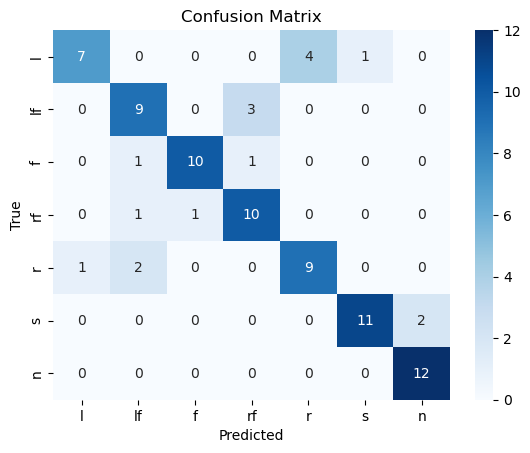

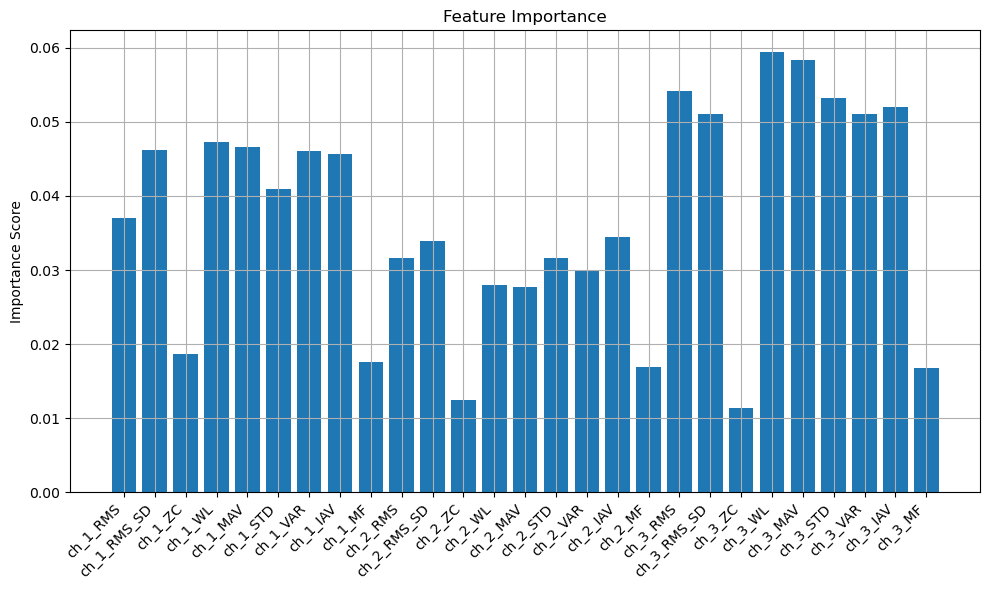

['6_classes_scaler_rf_cont_18_06.pkl']

In [23]:
# ------------------------------- RANDOM FOREST TREE

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Scale features
scaler_RF = StandardScaler()
X_train_scaled_array = scaler_RF.fit_transform(X_train)
X_test_scaled_array = scaler_RF.transform(X_test)

# Wrap back into DataFrames with feature names
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X.columns)

# 3. Train & 4. Pred
clf_RF = RandomForestClassifier(n_estimators=500, random_state=42)
if USE_SCALING == 1:
    clf_RF.fit(X_train_scaled, y_train) # with scaling
    y_pred = clf_RF.predict(X_test_scaled)
else:
    clf_RF.fit(X_train, y_train)
    y_pred = clf_RF.predict(X_test)

# 5. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])

print(f"Random Forest Test Accuracy: {acc:.3f}")

# 6. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'],
            yticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Plot feature importance
importances = clf_RF.feature_importances_
feature_names = X.columns if hasattr(X, 'columns') else [f'feat{i}' for i in range(X.shape[1])]

plt.figure(figsize=(10,6))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Save model and scaler
joblib.dump(clf_RF, "6_classes_rf_cont_18_06.pkl")
joblib.dump(scaler_RF, "6_classes_scaler_rf_cont_18_06.pkl")


## Random Forest Tree with Feature Selection

Random Forest Test Accuracy: 0.837


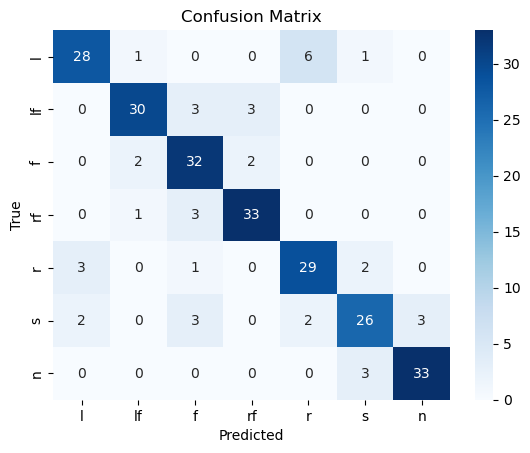

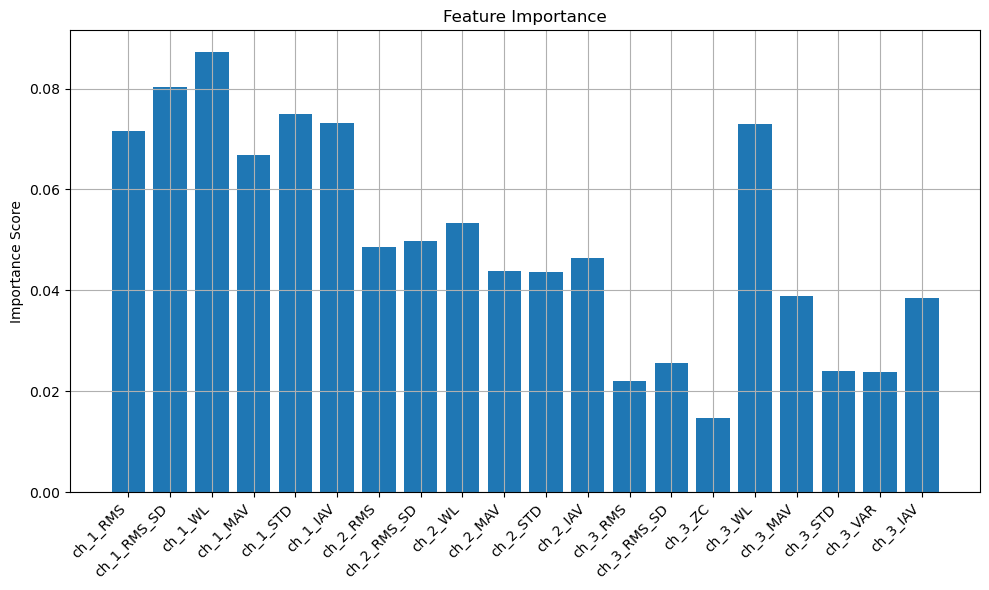

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pandas as pd

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Optional: scale features
if USE_SCALING:
    scaler_RF = StandardScaler()
    X_train_array = scaler_RF.fit_transform(X_train)
    X_test_array = scaler_RF.transform(X_test)
    X_train_df = pd.DataFrame(X_train_array, columns=X.columns)
    X_test_df = pd.DataFrame(X_test_array, columns=X.columns)
else:
    X_train_df = X_train.copy()
    X_test_df = X_test.copy()

# 3. Optional: feature selection
if USE_FEATURESELECTION:
    selector_RF = SelectKBest(score_func=f_classif, k=k)
    X_train_array = selector_RF.fit_transform(X_train_df, y_train)
    X_test_array = selector_RF.transform(X_test_df)

    selected_features = X_train_df.columns[selector_RF.get_support()]
    X_train_final = pd.DataFrame(X_train_array, columns=selected_features)
    X_test_final = pd.DataFrame(X_test_array, columns=selected_features)
else:
    X_train_final = X_train_df
    X_test_final = X_test_df
    selected_features = X.columns  # for plotting

# 4. Train classifier
clf_RF = RandomForestClassifier(n_estimators=500, random_state=42)
clf_RF.fit(X_train_final, y_train)
y_pred = clf_RF.predict(X_test_final)

# 5. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])

print(f"Random Forest Test Accuracy: {acc:.3f}")

# 6. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'],
            yticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Plot feature importance
importances = clf_RF.feature_importances_

plt.figure(figsize=(10, 6))
plt.bar(selected_features, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Save model (and optionally scaler and selector)
joblib.dump(clf_RF, "6_classes_rf_17_09.pkl")
if USE_SCALING:
    joblib.dump(scaler_RF, "6_classes_scaler_rf_17_09.pkl")
if USE_FEATURESELECTION:
    joblib.dump(selector_RF, "6_classes_selector_rf_17_09.pkl")


## Cross Validation

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
import joblib
import numpy as np
import pandas as pd

# ----------------------------- CONFIG -----------------------------
n_splits = 5  # Number of CV folds
random_state = 42
labels_order = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']

# ------------------------ CLASSIFIER PIPELINE ------------------------
steps = []
if USE_SCALING == 1:
    steps.append(('scaler', StandardScaler()))
if USE_FEATURESELECTION == 1:
    steps.append(('feature_selection', SelectKBest(score_func=f_classif, k=k)))
steps.append(('classifier', RandomForestClassifier(n_estimators=500, random_state=random_state)))

pipeline = Pipeline(steps)

# -------------------------- CROSS-VALIDATION --------------------------
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

scoring = {
    'accuracy': 'accuracy'
}

cv_results = cross_validate(
    pipeline, X, y,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    return_train_score=True
)

# -------------------------- RESULTS SUMMARY --------------------------
print(f"\nCross-Validation Accuracy Scores: {cv_results['test_accuracy']}")
print(f"Mean Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Std Deviation: {np.std(cv_results['test_accuracy']):.3f}")




Cross-Validation Accuracy Scores: [0.78947368 0.87719298 0.80701754 0.80357143 0.69642857]
Mean Accuracy: 0.795
Std Deviation: 0.058


## PCA 

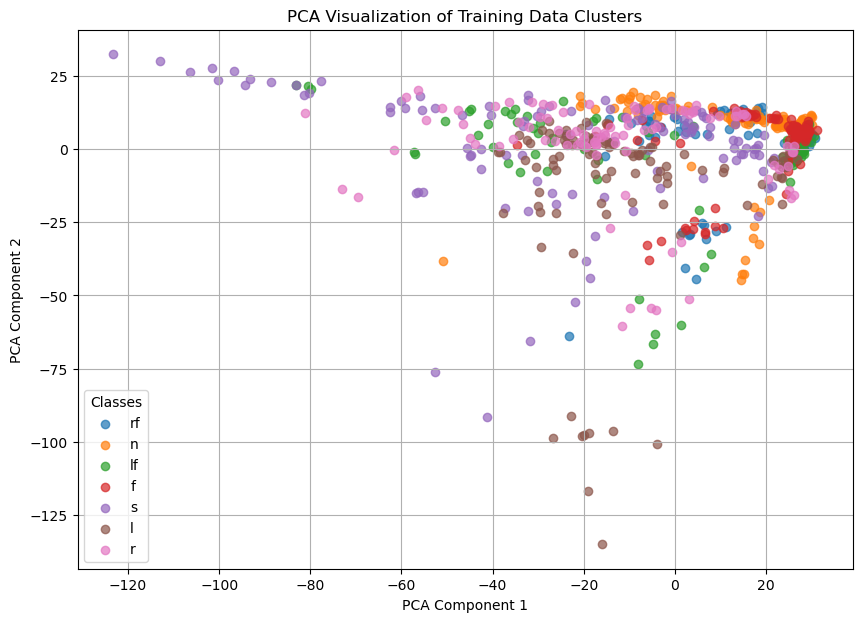

In [29]:
from sklearn.decomposition import PCA

# 2.5 PCA for visualization (2D)
pca = PCA(n_components=2)

if USE_SCALING == 1:
    X_train_pca = pca.fit_transform(X_train_scaled)
else:
    X_train_pca = pca.fit_transform(X_train)

# Plot
plt.figure(figsize=(10, 7))
for label in y_train.unique():
    idx = y_train == label
    plt.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], label=label, alpha=0.7)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Training Data Clusters')
plt.legend(title='Classes')
plt.grid(True)
plt.show()


## SVM

SVM Test Accuracy: 0.698


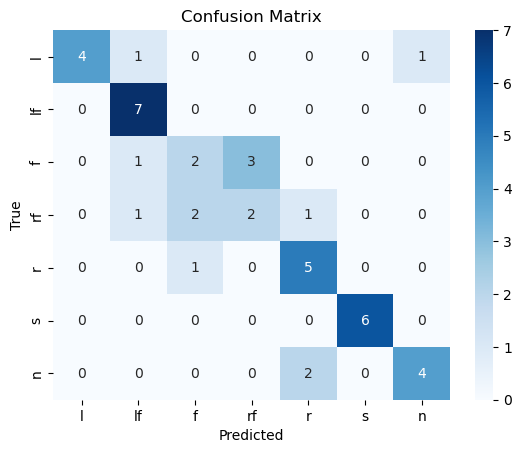

In [50]:
# ----------------------------- SUPPORT VECTOR MACHINE

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pandas as pd

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Scale features
scaler = StandardScaler()
X_train_scaled_array = scaler.fit_transform(X_train)
X_test_scaled_array = scaler.transform(X_test)

# Wrap back into DataFrames with feature names
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X.columns)

# 3. Train 
clf_SVM = SVC(kernel='linear', C=1.0, gamma='scale', class_weight='balanced')
clf_SVM.fit(X_train_scaled, y_train)

# 4. Predict
y_pred = clf_SVM.predict(X_test_scaled)

# 5. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])

print(f"SVM Test Accuracy: {acc:.3f}")

# 6. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'],
            yticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Save model and scaler
#joblib.dump(clf_SVM, "7_classes_svm.pkl")
#joblib.dump(scaler, "scaler_svm.pkl")


# Test

## Random Forest Tree

Random Forest Test Accuracy: 0.887


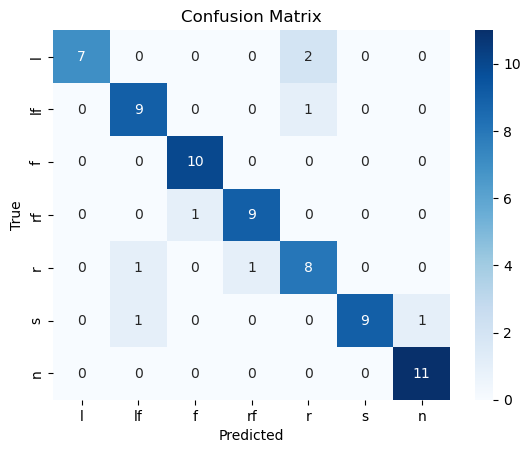

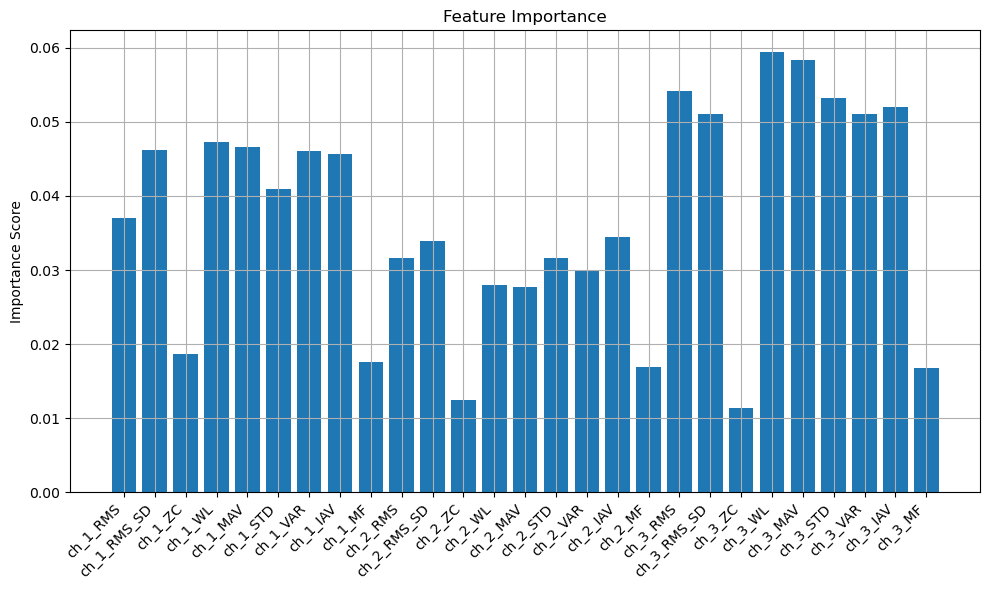

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if USE_SCALING == 1:
    Xt_scaled_array = scaler_RF.transform(Xt)
    Xt_scaled = pd.DataFrame(Xt_scaled_array, columns=Xt.columns)
    y_pred = clf_RF.predict(Xt_scaled)
else:
    y_pred = clf_RF.predict(Xt)
    
# Evaluate accuracy
acc = accuracy_score(yt, y_pred)
print(f"Random Forest Test Accuracy: {acc:.3f}")

# Compute confusion matrix
labels_order = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
cm = confusion_matrix(yt, y_pred, labels=labels_order)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order,
            yticklabels=labels_order)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot feature importance
importances = clf_RF.feature_importances_
feature_names = Xt.columns if hasattr(Xt, 'columns') else [f'feat{i}' for i in range(Xt.shape[1])]

plt.figure(figsize=(10,6))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Random Forest Tree with Feature Selection

Random Forest Test Accuracy: 0.810


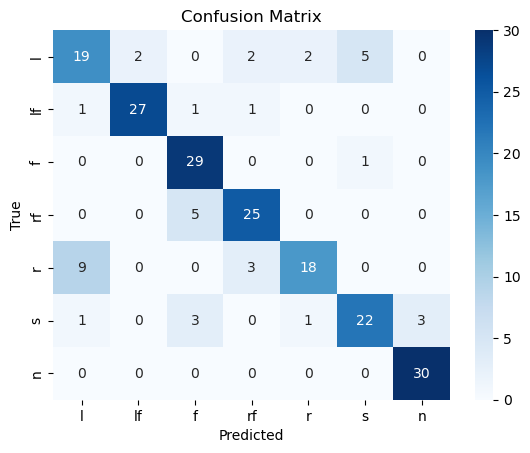

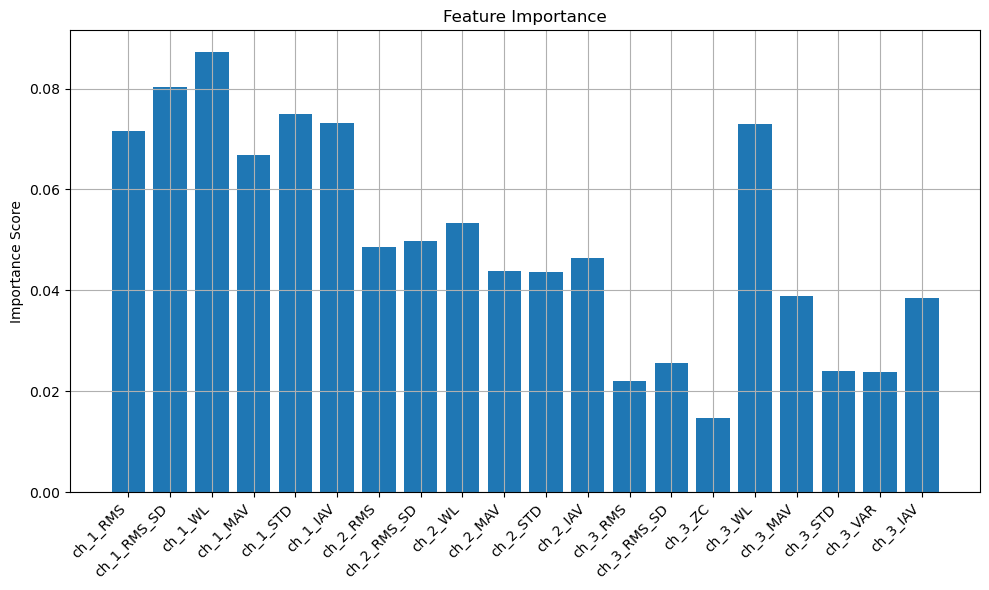

In [114]:

# Apply scaling if used during training
if USE_SCALING == 1:
    Xt_scaled_array = scaler_RF.transform(Xt)
    Xt_scaled = pd.DataFrame(Xt_scaled_array, columns=Xt.columns)
else:
    Xt_scaled = Xt.copy()

# Apply feature selection if used during training
if USE_FEATURESELECTION == 1:
    Xt_selected_array = selector_RF.transform(Xt_scaled)
    selected_features = Xt_scaled.columns[selector_RF.get_support()]
    Xt_selected = pd.DataFrame(Xt_selected_array, columns=selected_features)
else:
    Xt_selected = Xt_scaled

# Make prediction
y_pred = clf_RF.predict(Xt_selected)

# Evaluate accuracy
acc = accuracy_score(yt, y_pred)
print(f"Random Forest Test Accuracy: {acc:.3f}")

# Compute confusion matrix
labels_order = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
cm = confusion_matrix(yt, y_pred, labels=labels_order)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order,
            yticklabels=labels_order)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot feature importance
importances = clf_RF.feature_importances_
feature_names = Xt_selected.columns

plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()
